필요한 패키지를 설치합니다.
'wandb'는 train loss등 여러 metric과 hyper parameter tuning을 도와주는 서비스 입니다.

In [1]:
!pip install transformers datasets wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 98.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 k

WandB에 login하고 사용할 프로젝트명을 환경변수로 설정합니다.

In [2]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
%env WANDB_PROJECT=vit-cifar10

env: WANDB_PROJECT=vit-cifar10


HuggingFace의 Vision transformer를 모델로 사용합니다.

In [21]:
import pandas as pd
import numpy as np
import math
import torch
from collections import defaultdict
from PIL import Image, ImageDraw
from transformers import ViTFeatureExtractor, ViTForImageClassification, TrainingArguments, Trainer
from datasets import load_dataset, load_metric
from sklearn import metrics

Image classification을 위한 데이터셋은 cifar10 데이터셋을 이용합니다.  
https://www.cs.toronto.edu/~kriz/cifar.html

In [11]:
train_ds = load_dataset("cifar10", split="train")
test_ds = load_dataset("cifar10", split="test[:90%]")
val_ds = load_dataset("cifar10", split="test[-10%:]")

In [6]:
display(train_ds)
display(test_ds)
display(val_ds)

Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})

Dataset({
    features: ['img', 'label'],
    num_rows: 9000
})

Dataset({
    features: ['img', 'label'],
    num_rows: 1000
})

모델에 전달할 label parameter들을 셋팅합니다.

In [23]:
labels = train_ds.features['label']
labels

ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)

In [24]:
id2label={str(i): c for i, c in enumerate(labels.names)}
label2id={c: str(i) for i, c in enumerate(labels.names)}
display(id2label)
display(label2id)

{'0': 'airplane',
 '1': 'automobile',
 '2': 'bird',
 '3': 'cat',
 '4': 'deer',
 '5': 'dog',
 '6': 'frog',
 '7': 'horse',
 '8': 'ship',
 '9': 'truck'}

{'airplane': '0',
 'automobile': '1',
 'bird': '2',
 'cat': '3',
 'deer': '4',
 'dog': '5',
 'frog': '6',
 'horse': '7',
 'ship': '8',
 'truck': '9'}

cifar10은 10종류로 분류되는 이미지셋입니다.

['ship', 'automobile', 'frog']


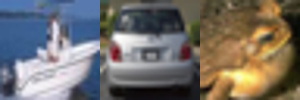

In [25]:
def show_images(ds, image_no_list, size=(100, 100)):
    if image_no_list == []:
        return "None"
    w, h = size
    column_size = 3
    row_size = math.ceil(len(image_no_list)/column_size)
    grid = Image.new('RGB', size=(column_size * w, row_size * h))
    draw = ImageDraw.Draw(grid)
    
    labels = []
    for idx, image_no in enumerate(image_no_list):
        image = val_ds[image_no]['img']
        labels.append(id2label[str(val_ds[image_no]['label'])])
        box = (idx % column_size * w, idx // column_size * h)
        grid.paste(image.resize(size), box=box)

    print(labels)
    
    return grid

show_images(train_ds, [0,1,2])

pre-trained된 모델로부터 fetature_extractor를 불러옵니다. 

In [8]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
feature_extractor

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

Input 데이터셋을 만듭니다.

In [9]:
def transform(example_batch):
    inputs = feature_extractor([x for x in example_batch['img']], return_tensors='pt')
    
    inputs['labels'] = example_batch['label']
    return inputs

prepared_train_ds = train_ds.with_transform(transform)
prepared_test_ds = test_ds.with_transform(transform)

In [10]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

사용할 metric을 불러옵니다.

In [11]:
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

<ipython-input-11-a00513a56fba>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


fine tuning을 위한 model을 선언합니다.

In [17]:
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(labels.names),
    id2label=id2label,
    label2id=label2id
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training을 위한 파라미터 값을 셋팅합니다.

In [19]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    evaluation_strategy="epoch",
    num_train_epochs=3,
    fp16=True,
    save_strategy = "epoch",
    logging_steps=100,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='wandb'
)

In [20]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train_ds,
    eval_dataset=prepared_test_ds,
    tokenizer=feature_extractor,
)

모델을 학습시킵니다.

In [21]:
train_results = trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


wandb: Currently logged in as: mypeacefulcode. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.184900,0.200261,0.936889
2,0.065500,0.124141,0.967444
3,0.012300,0.089997,0.979778


WandB에 모델 학습이 종료되었음을 알립니다.

In [23]:
wandb.finish()

eval/accuracy,▁▆█
eval/loss,█▃▁
eval/runtime,▄█▁
eval/samples_per_second,▅▁█
eval/steps_per_second,▅▁█
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
train/loss,█▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁


학습한 metrics 결과입니다.

In [22]:
trainer.log_metrics("train", train_results.metrics)

***** train metrics *****
  epoch                    =           3.0
  total_flos               = 10826282096GF
  train_loss               =        0.1239
  train_runtime            =    0:45:52.68
  train_samples_per_second =        54.492
  train_steps_per_second   =         3.406


In [26]:
trainer.save_model()

전체 데이터셋에서 학습에 사용하지 않은 데이터셋으로 모델을 평가해봅니다.

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

학습한 모델을 불러옵니다.

In [16]:
feature_extractor = ViTFeatureExtractor.from_pretrained("./results")
model = ViTForImageClassification.from_pretrained("./results").to(device)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Input데이터를 만들고 모델로부터 예측결과값을 받습니다.

In [17]:
images = val_ds['img']
labels = val_ds['label']
inputs = feature_extractor(images, return_tensors="pt").to(device)

In [18]:
with torch.no_grad():
    logits = model(**inputs).logits

F1 score 97.85% 수준의 모델이 학습된것을 확인했습니다.

In [19]:
predicted_labels = [ x.argmax(-1).item() for x in logits ]
average_type = "binary" if val_ds.features['label'].num_classes == 2 else "macro"

print("Accuracy score:{}".format(metrics.accuracy_score(labels, predicted_labels)))
print("Recall score:{}".format(metrics.recall_score(labels, predicted_labels, average=average_type)))
print("Precision score:{}".format(metrics.precision_score(labels, predicted_labels, average=average_type)))
print("F1 score:{}".format(metrics.f1_score(labels, predicted_labels, average=average_type)))

Accuracy score:0.979
Recall score:0.9786308313603117
Precision score:0.9786321227759489
F1 score:0.9785662667170548
